<a href="https://colab.research.google.com/github/Culty48/MillionSongDatasetMining/blob/main/Data_Mining_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ---------------- RUN ONCE: SAVING DATA ON THE DRIVE----------------
from google.colab import drive
import os

# 1️ Mount Google Drive
drive.mount('/content/drive')

# 2️ Paths in Drive
dataset_path = '/content/drive/MyDrive/MillionSongSubset'
getters_path = '/content/drive/MyDrive/hdf5_getters.py'

# 3️ Download & extract Million Song Subset if not already in Drive
if not os.path.exists(dataset_path):
    print("Downloading Million Song Subset...")
    !wget -O MillionSongSubset.tar.gz http://labrosa.ee.columbia.edu/~dpwe/tmp/millionsongsubset.tar.gz
    !mkdir -p "$dataset_path"
    !tar -xvzf MillionSongSubset.tar.gz -C "$dataset_path"
    !rm MillionSongSubset.tar.gz
    print(" Dataset downloaded and extracted to Drive.")
else:
    print("Million Song Subset already exists in Drive.")

# 4️ Download hdf5_getters.py if not already in Drive
if not os.path.exists(getters_path):
    print("Downloading hdf5_getters.py...")
    !wget -O "$getters_path" https://raw.githubusercontent.com/tbertinmahieux/MSongsDB/master/PythonSrc/hdf5_getters.py
    print(" hdf5_getters.py downloaded to Drive.")
else:
    print("hdf5_getters.py already exists in Drive.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Million Song Subset already exists in Drive.
hdf5_getters.py already exists in Drive.


In [2]:
# --- FIX THE GETTER ISSUE ---
!sed -i 's/tables.openFile/tables.open_file/g' /content/drive/MyDrive/hdf5_getters.py
print(" Patched hdf5_getters.py for PyTables compatibility")

# ---------------- REUSABLE ----------------
import sys
import glob
import importlib

# 1️ Add Drive folder to Python path
sys.path.append('/content/drive/MyDrive')

# 2️ Import or reload hdf5_getters
import hdf5_getters
importlib.reload(hdf5_getters)
print("hdf5_getters imported successfully!")

# 3️ Path to dataset
dataset_path = '/content/drive/MyDrive/MillionSongSubset'

# 4️ Find all .h5 files recursively
files = glob.glob(dataset_path + '/**/*.h5', recursive=True)
print(f"Number of songs found: {len(files)}")
print("First 5 files:", files[:5])

# 5️ Open the first song and read metadata
if files:
    h5 = hdf5_getters.open_h5_file_read(files[1])
    artist = hdf5_getters.get_artist_name(h5).decode('utf-8')
    title = hdf5_getters.get_title(h5).decode('utf-8')
    h5.close()
    print(f" {artist} – {title}")
else:
    print("No .h5 files found in dataset.")


 Patched hdf5_getters.py for PyTables compatibility
hdf5_getters imported successfully!
Number of songs found: 10000
First 5 files: ['/content/drive/MyDrive/MillionSongSubset/MillionSongSubset/B/A/H/TRBAHJW128F92CC8B4.h5', '/content/drive/MyDrive/MillionSongSubset/MillionSongSubset/B/A/H/TRBAHED128F426A1C2.h5', '/content/drive/MyDrive/MillionSongSubset/MillionSongSubset/B/A/H/TRBAHNM128F426895A.h5', '/content/drive/MyDrive/MillionSongSubset/MillionSongSubset/B/A/H/TRBAHEH128F9327D39.h5', '/content/drive/MyDrive/MillionSongSubset/MillionSongSubset/B/A/H/TRBAHPQ128F4230D15.h5']
 Beatnuts with Lil' Donny – Spelling Beatnuts with Lil' Donny


In [3]:
import os
import pandas as pd
import h5py
import sys

# Path to the Million Song Subset data
dataset_path = '/content/drive/MyDrive/MillionSongSubset'

# Path to hdf5_getters.py
sys.path.append('/content/drive/MyDrive')
import hdf5_getters as GETTERS


def load_mss_dataframe(dataset_path, max_files=None):
    """
    Loads song data from the Million Song Subset into a pandas DataFrame.
    max_files: limit number of songs for faster testing (optional)
    """

    rows = []
    count = 0

    for root, dirs, files in os.walk(dataset_path):

        for file in files:
            if not file.endswith('.h5'):
                continue

            file_path = os.path.join(root, file)

            try:
              h5 = GETTERS.open_h5_file_read(file_path)
            except:
              print("Skipping unreadable file:", file_path)
              continue

            # ---- Extract attributes----
            try:
                row = {
                    "song_hotttnesss":       GETTERS.get_song_hotttnesss(h5),
                    "artist_hotttnesss":     GETTERS.get_artist_hotttnesss(h5),
                    "artist_familiarity":    GETTERS.get_artist_familiarity(h5),
                    "year":                  GETTERS.get_year(h5),
                    "duration":              GETTERS.get_duration(h5),
                    "energy":                GETTERS.get_energy(h5),
                    "tempo":                 GETTERS.get_tempo(h5),
                    "loudness":              GETTERS.get_loudness(h5),
                    "mode":                  GETTERS.get_mode(h5),
                    "key":                   GETTERS.get_key(h5),
                    "time_signature":        GETTERS.get_time_signature(h5),
                    "title":                 GETTERS.get_title(h5).decode('utf-8', errors='ignore'),
                    "artist_name":           GETTERS.get_artist_name(h5).decode('utf-8', errors='ignore'),
                    "track_id":              GETTERS.get_track_id(h5).decode('utf-8', errors='ignore'),
                }
            except:
                h5.close()
                continue

            rows.append(row)
            h5.close()

            count += 1
            if max_files and count >= max_files:
                break

        if max_files and count >= max_files:
            break

    return pd.DataFrame(rows)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor


def preprocess_data(train_df, test_df):
    """
    Preprocess the Million Song Subset dataset.
    Parameters: df dataset to be preprocessed
    Returns: X_train_selected, X_test_selected, y_train, y_test
    These outputs are fully ready to be passed into the custom KNN algorithm.
    """
    # Remove songs with missing hotttness values
    train_df = train_df.dropna(subset=['song_hotttnesss'])
    test_df = test_df.dropna(subset=['song_hotttnesss'])

    # Extract target variable (continuous value)
    y_train = train_df['song_hotttnesss'].values
    y_test = test_df['song_hotttnesss'].values

    # Drop non-predictive identifiers and keep only features
    X_train = train_df.drop(['song_hotttnesss', 'track_id', 'title', 'artist_name'],
                axis=1, errors='ignore')
    X_test = test_df.drop(['song_hotttnesss', 'track_id', 'title', 'artist_name'],
                axis=1, errors='ignore')

    # Identify numeric and categorical columns
    num_features = X_train.select_dtypes(include=['float64', 'int64']).columns
    cat_features = X_train.select_dtypes(include=['object', 'category']).columns

    # Pipeline for numeric columns:
    #    - Impute missing values using median
    #    - uses median to ignore large and noisy data, handles skewed distributions
    #    - Scale using StandardScaler
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Pipeline for categorical columns:
    #    - Impute missing categories
    #    - Uses most frequent (mode) because arithmetic is not supported
    #    - Mode is usually right
    #    - Convert categories using One-Hot Encoding
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine numeric + categorical preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_features),
            ('cat', categorical_transformer, cat_features)
        ]
    )

    # Fit preprocessing on training data, transform both sets
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Feature Selection using RandomForestRegressor:
    #     - Learns which features are most important for predicting hotttness
    #     - Selects only the informative ones
    selector = SelectFromModel(
        estimator=RandomForestRegressor(n_estimators=200, random_state=42),
        threshold="median"  # keep features >= median importance, median ignores noisy data
    )

    # Fit selector on processed training data
    selector.fit(X_train_processed, y_train)

    # Apply feature selection to both train and test sets
    X_train_selected = selector.transform(X_train_processed)
    X_test_selected = selector.transform(X_test_processed)

    return X_train_selected, X_test_selected, y_train, y_test


In [5]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np

# Map regression hotness value to a class (0=low, 1=medium, 2=high)
def label_map(h, y_train):
    threshold_low = np.percentile(y_train, 33)
    threshold_high = np.percentile(y_train, 66)

    if h < threshold_low:
        return 0
    elif h < threshold_high:
        return 1
    else:
        return 2

# K-Fold CV and hyperparameter tuning for custom knn_hybrid
# Returns best k and average accuracy per k
def cross_val_tune_k(df, k_values, n_splits=5, target_col='song_hotttnesss', id_col='track_id'):
    fold_result = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(df):
        # Split data for training and testing data
        train_data = df.iloc[train_index].copy()
        test_data = df.iloc[test_index].copy()
        test_ids = test_data[id_col].values  # Save test IDs before preprocessing

        # Preprocess fold
        X_train_sel, X_test_sel, y_train, y_test = preprocess_data(train_data, test_data)

        # Get test IDs after dropping missing targets
        test_ids = test_data.dropna(subset=[target_col])[id_col].values

        # Map true targets to numeric labels using loop
        y_true_labels = []
        for h in y_test:
            y_true_labels.append(label_map(h, y_train))

        # Loop over candidate k values
        for k in k_values:
            # Predict with KNN
            result_df = knn_hybrid(X_test_sel, X_train_sel, y_train, test_ids, k)

            # Convert predicted class names to numeric values
            y_pred_labels = result_df['Hotness CLASS'].map({'low': 0, 'medium': 1, 'high': 2}).values

            # Compute accuracy
            acc = accuracy_score(y_true_labels, y_pred_labels)
            fold_result.append((k, acc))

    # Convert results to DataFrame for aggregation
    results_df = pd.DataFrame(fold_result, columns=['k', 'accuracy'])

    # Compute average accuracy per k and select best k
    avg_scores = results_df.groupby('k')['accuracy'].mean()
    best_k = avg_scores.idxmax()

    return best_k, avg_scores.to_dict()


In [6]:
import numpy as np

def knn_hybrid(X_test, X_train, y_train, test_ids, k):

    # Thresholds based on training hotness
    threshold_low = np.percentile(y_train, 33)
    threshold_high = np.percentile(y_train, 66)

    output_list = []

    # For each test instance
    for i, x in enumerate(X_test):
        # Euclidean distances to all train points
        distances = np.sqrt(np.sum((X_train - x)**2, axis=1))

        # pick k nearest neighbors
        neighbors_k = np.argsort(distances)[:k]

        # regression: average their hotness
        predicted_hotness = np.mean(y_train[neighbors_k])

        # classify
        label = ""
        if predicted_hotness < threshold_low:
            label = "low"
        elif predicted_hotness < threshold_high:
            label = "medium"
        else:
            label = "high"

        # store in (ORDER_ID, CLASS) form
        output_list.append((test_ids[i], label))

    # convert to DataFrame in final required format
    result_df = pd.DataFrame(output_list, columns=["ORDER_ID", "Hotness CLASS"])

    return result_df


Best k: 11
Average accuracy per k: {3: 0.4996577961490735, 5: 0.5020165570480701, 7: 0.5175900033318559, 9: 0.522959652390951, 11: 0.5338795439081597, 13: 0.5262217785885227}


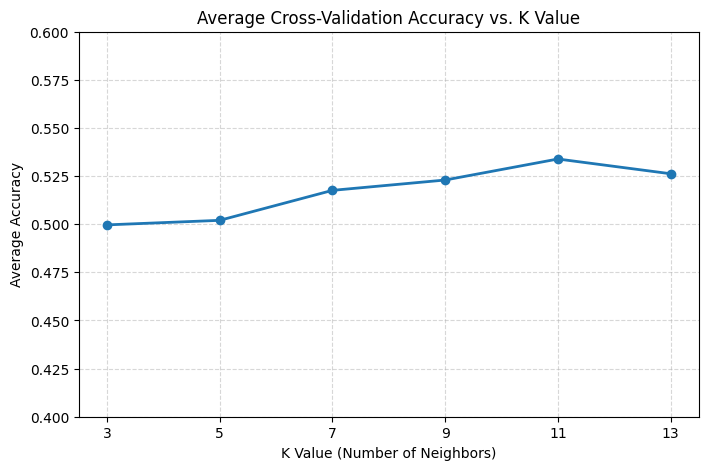

In [8]:
df = load_mss_dataframe(dataset_path, max_files=2500)
df.head()

k_values = [3,5,7,9,11,13]
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
best_k, avg_scores = cross_val_tune_k(df, k_values, n_splits=5, target_col='song_hotttnesss', id_col='track_id')


# Tune k using only training data
best_k, avg_scores = cross_val_tune_k(train_df, k_values, n_splits=5)
print("Best k:", best_k)
print("Average accuracy per k:", avg_scores)

import matplotlib.pyplot as plt

# Convert dictionary to sorted lists
ks = sorted(avg_scores.keys())
accs = [avg_scores[k] for k in ks]

plt.figure(figsize=(8, 5))
plt.plot(ks, accs, marker='o', linestyle='-', linewidth=2)

plt.title("Average Cross-Validation Accuracy vs. K Value")
plt.xlabel("K Value (Number of Neighbors)")
plt.ylabel("Average Accuracy")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(ks)
plt.ylim(0.4, 0.6)

plt.show()

In [9]:
# Gradient Boosting (best model)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
import numpy as np
import pandas as pd

def train_gradient_boosting(X_train, y_train, X_test, threshold_low, threshold_high):
    # Train model
    gbr = GradientBoostingRegressor(
      n_estimators=300,
      learning_rate=0.05,
      max_depth=3,
      random_state=42
    )
    gbr.fit(X_train, y_train)

    # Predict numeric hotness
    y_pred_hotness = gbr.predict(X_test)

    # Convert to labels
    def to_label(h):
        if h < threshold_low:
            return "low"
        elif h < threshold_high:
            return "medium"
        else:
            return "high"

    y_pred_label = [to_label(v) for v in y_pred_hotness]

    return y_pred_label, y_pred_hotness


# Gaussian Naive Bayes (bad model?)
def train_gaussian_nb(X_train, y_train, X_test, threshold_low, threshold_high):
    """
    3-class Gaussian Naive Bayes classification.
    Converts numeric hotness → categorical labels (low/medium/high),
    then trains a GNB classifier directly.
    """

    # ---- Convert numeric hotness → labels for training ----
    def to_label(h):
        if h < threshold_low:
            return "low"
        elif h < threshold_high:
            return "medium"
        else:
            return "high"

    y_train_label = [to_label(v) for v in y_train]

    # ---- Train Gaussian Naive Bayes classifier ----
    gnb = GaussianNB()
    gnb.fit(X_train, y_train_label)

    # ---- Predict labels directly ----
    y_pred_label = gnb.predict(X_test)

    return y_pred_label



In [10]:
# Compare accuracy

# === Preprocess train/test split ===
X_train, X_test, y_train, y_test = preprocess_data(train_df, test_df)

# Track IDs for later output
test_ids = test_df["track_id"].values


def evaluate_model(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

# Convert y_test numeric → labels
def convert_to_labels(y_test, threshold_low, threshold_high):
    labels = []
    for v in y_test:
        if v < threshold_low:
            labels.append("low")
        elif v < threshold_high:
            labels.append("medium")
        else:
            labels.append("high")
    return labels

# Threshold from training set
threshold_low  = np.percentile(y_train, 33)
threshold_high = np.percentile(y_train, 66)

y_test_label = convert_to_labels(y_test, threshold_low, threshold_high)

# 1. Hybrid KNN
knn_output = knn_hybrid(X_test, X_train, y_train, test_ids, 11)
y_pred_knn = knn_output["Hotness CLASS"].tolist()

acc_knn = evaluate_model(y_test_label, y_pred_knn)

# 2. Gaussian Naive Bayes
y_pred_gnb = train_gaussian_nb(X_train, y_train, X_test, threshold_low, threshold_high)
acc_gnb = evaluate_model(y_test_label, y_pred_gnb)

# 3. Gradient Boosting
y_pred_gb, _ = train_gradient_boosting(X_train, y_train, X_test, threshold_low, threshold_high)
acc_gb = evaluate_model(y_test_label, y_pred_gb)

# Show table
pd.DataFrame({
    "Model": ["GaussianNB", "Hybrid KNN", "Gradient Boosting"],
    "Accuracy": [acc_gnb, acc_knn, acc_gb]
})




,Model,Accuracy
0,GaussianNB,0.520913
1,Hybrid KNN,0.532319
2,Gradient Boosting,0.543726
